# Chronic Kidney Disease (CKD) Prediction

In this analysis I will explore various predictive algorithims for predicting CKD

Additionally,


<font color = grey> **This is a work in progress...more improvements to come**
___

**Import the necessary packages**

In [1]:
## Standard Packages
import pandas as pd
import numpy  as np

## Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## EDA & preprocessing
from sklearn.impute import KNNImputer
from scipy import stats
from scipy.stats import chi2
from scipy.stats import chi2_contingency 
# from sklearn import preprocessing

## Modeling 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import GridSearchCV


## Set options to view all columns of dataframes
pd.set_option('max_columns', None)

**Define custom functions used throughout analysis**

In [2]:
def check_missing_data(df):
    
    """
    This function will print the data types and number of missing values for each variable, and display a heatmap to visualize the missing values
    
    Inputs:
    df - dataframe to check for missing values 
    """
        
    ## Set figure size
    plt.figure(figsize = (12, 8))

    ## Create heatmap to visualize 
    sns.heatmap(df_orig.isnull(), yticklabels = False, cbar = False, cmap = 'BuGn_r')
    plt.title('Review Amount of Missing Data - Filtered Dataset', size = 15)    
    plt.show()
    
    ## Print data types and number of missing values for each variable
    df_orig.info()


In [3]:
def model_eval(Model, y_actual, y_predictions):

   
    """
    This fuctions returns a confusion matrix & evaluation metrics, & the profit 
    
    earn $1,300 for True Positives
    lose $100 for a False Positive (incorrectly identified as having CKD)

    """

    ##################### Confusion Matrix #####################   
    conf_mat = pd.DataFrame(confusion_matrix(y_actual, y_predictions),
                            index = Model.classes_, columns = Model.classes_)  


    ################ Calculate Profit ################
    profit = conf_mat.iloc[1,1]*13000 - conf_mat.iloc[0,1]*100
    
    ################ Classification Report DataFrame ################
    ## Create Dataframe (contains Precision, Recall, F1, Support)
    report = pd.DataFrame(list(precision_recall_fscore_support(y_actual, y_predictions)),
                index=['Precision', 'Recall', 'F1-score', 'Support']).T

    ## Re-label indexes to match label of classes
    report.set_index(Model.classes_, inplace=True)

    ## Add the 'Avg/Total' row
    report.loc['Avg/Total', :] = precision_recall_fscore_support(y_actual, y_predictions, average='weighted')
    report.loc['Avg/Total', 'Support'] = report['Support'].sum()

    ## Round Results
    report = report.round(2)

    print("Confusion Matrix: \n", conf_mat, '\n')    
    print('Proft: ', profit) 
    print('F1 Score: ', report.loc['Avg/Total', 'F1-score'], '\n')
    print('Model Results:')

    return report   

In [4]:
def model_eval_for_df(Model_Name, Model, y_actual, y_predictions):

   
    """
    This fuctions returns a the F1 score & profit; same approach as prior function, but returns the evaluation metrics to put into a dataframe
    
    earn $1,300 for True Positives
    lose $100 for a False Positive (incorrectly identified as having CKD)
    
    Model_Name: input 

    """

    ##################### Confusion Matrix #####################   
    conf_mat = pd.DataFrame(confusion_matrix(y_actual, y_predictions),
                            index = Model.classes_, columns = Model.classes_)  


    ################ Calculate Profit ################
    profit = conf_mat.iloc[1,1]*13000 - conf_mat.iloc[0,1]*100
    
    ################ Classification Report DataFrame ################
    ## Create Dataframe (contains Precision, Recall, F1, Support)
    report = pd.DataFrame(list(precision_recall_fscore_support(y_actual, y_predictions)),
                index=['Precision', 'Recall', 'F1-score', 'Support']).T

    ## Re-label indexes to match label of classes
    report.set_index(Model.classes_, inplace=True)

    ## Add the 'Avg/Total' row
    report.loc['Avg/Total', :] = precision_recall_fscore_support(y_actual, y_predictions, average='weighted')
    report.loc['Avg/Total', 'Support'] = report['Support'].sum()

    ## Round Results
    report = report.round(2)
    
    ## Calc AUC
    AUC = roc_auc_score(y_actual, y_predictions)

#     print('Proft: ', profit) 
#     print('F1 Score: ', report.loc['Avg/Total', 'F1-score'], '\n')

    return [Model_Name, report.loc['Avg/Total', 'F1-score'], AUC, profit]   

**Import data**

In [5]:
## Import dataset
df_orig = pd.read_csv('CKD Data_Original.csv')

df_orig.head()

,ID,Age,Female,Racegrp,Educ,Unmarried,Income,CareSource,Insured,Weight,Height,BMI,Obese,Waist,SBP,DBP,HDL,LDL,Total Chol,Dyslipidemia,PVD,Activity,PoorVision,Smoker,Hypertension,Fam Hypertension,Diabetes,Fam Diabetes,Stroke,CVD,Fam CVD,CHF,Anemia,CKD
0,1,65,1,white,0.0,0.0,1.0,other,1.0,56.0,162.1,21.31,0.0,83.6,135.0,71.0,48.0,249.0,297.0,0,0,3.0,0.0,1,0.0,0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0
1,2,36,1,hispa,0.0,NaN,1.0,noplace,0.0,60.2,162.2,22.88,0.0,76.6,96.0,52.0,31.0,135.0,166.0,0,0,3.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,66,1,white,0.0,1.0,0.0,noplace,1.0,83.9,162.5,31.77,1.0,113.2,115.0,57.0,44.0,211.0,255.0,1,0,1.0,0.0,1,0.0,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,54,1,white,1.0,0.0,0.0,DrHMO,1.0,69.4,160.5,26.94,0.0,77.9,110.0,57.0,74.0,156.0,230.0,0,0,2.0,0.0,1,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,63,1,black,0.0,0.0,NaN,clinic,1.0,73.1,159.2,28.84,0.0,89.3,132.0,73.0,67.0,154.0,221.0,0,0,1.0,0.0,0,1.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Preparation & Exploratory Data Analysis (EDA)

**Handling missing data**

The first step in preparing the data for exploration is often reviewing for missing data

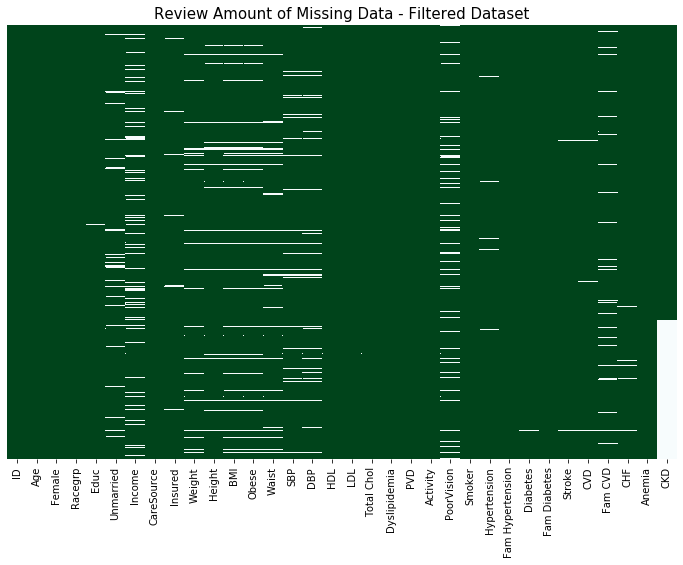

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8819 entries, 0 to 8818
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                8819 non-null   int64  
 1   Age               8819 non-null   int64  
 2   Female            8819 non-null   int64  
 3   Racegrp           8819 non-null   object 
 4   Educ              8799 non-null   float64
 5   Unmarried         8367 non-null   float64
 6   Income            7653 non-null   float64
 7   CareSource        8819 non-null   object 
 8   Insured           8706 non-null   float64
 9   Weight            8625 non-null   float64
 10  Height            8628 non-null   float64
 11  BMI               8529 non-null   float64
 12  Obese             8529 non-null   float64
 13  Waist             8505 non-null   float64
 14  SBP               8511 non-null   float64
 15  DBP               8439 non-null   float64
 16  HDL               8802 non-null   float64


In [6]:
check_missing_data(df_orig)

- The ID column is not needed as it does not provide any analytical value.  This column will be dropped.
- The target variable (CKD) is missing values.  For supervised learning, we can only work with the observations for which a label is available. Therefore, the dataset must be reduced to those 6,000 rows for which the label is available.

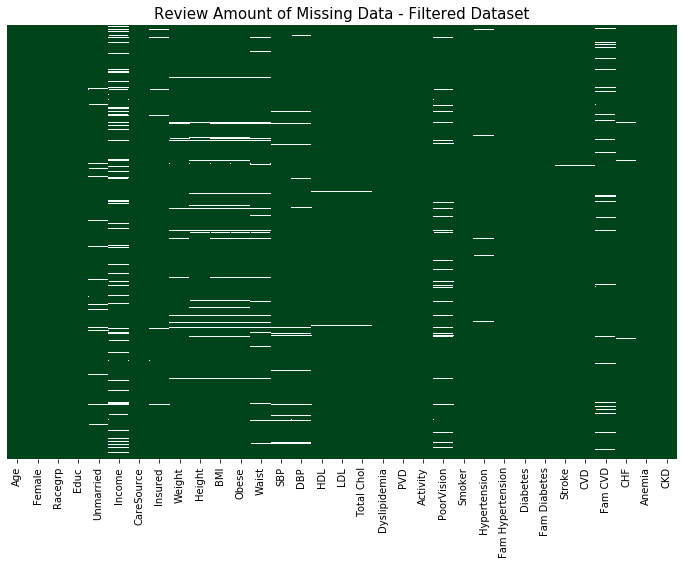

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               6000 non-null   int64  
 1   Female            6000 non-null   int64  
 2   Racegrp           6000 non-null   object 
 3   Educ              5985 non-null   float64
 4   Unmarried         5699 non-null   float64
 5   Income            5208 non-null   float64
 6   CareSource        6000 non-null   object 
 7   Insured           5922 non-null   float64
 8   Weight            5867 non-null   float64
 9   Height            5861 non-null   float64
 10  BMI               5794 non-null   float64
 11  Obese             5794 non-null   float64
 12  Waist             5785 non-null   float64
 13  SBP               5794 non-null   float64
 14  DBP               5748 non-null   float64
 15  HDL               5992 non-null   float64
 16  LDL               5992 non-null   float64


In [7]:
## Drop ID column
df_orig.drop('ID', axis = 1, inplace = True)

## Reduce the dataset to observations for which the target is available
df_orig = df_orig[df_orig['CKD'].notnull()]

check_missing_data(df_orig)

There are multiple options for handling missing data, each with its own pros and/or cons to be considered:

- Remove rows with missing values
    - Drawback: This results in information loss as it removes valuable data on which the model can be trained.

- Fill missing values with mean or mode of that given column
    - Drawback:  values imputed for a given row (i.e. a given patient in this analysis) will not be specific or personalized to that given observation.  The mean can be influenced by outliers of dissimilar observations.  This can also impact the correlation between features.
    
- ***Impute using KNN***:  instead of using the mean of the entire column to fill all missing values, this method uses a more customized approach for each missing value.  For an observation's  missing value, this method will first find a given number (K) of the most similar observations based on the data for other features, then impute the mean of the missing feature across just those K similar observations
    - Benefit: Imputation of missing values is more specific to a given observation rather than being generalized based on the entire dataset 
    

Based on these considerations, I will use KNN imputation to fill the missing data.  
There are, however, various considerations that need to be taken into account in how the data is prepared for imputation.
- Imputer can only work with numeric values.  Therefore, I will exclude any columns that are strings (data type = object); (excludes Race Group, Care Source).  Fortunately , neither of these columns have missing values.  
- The values for categorical variables will need to be discrete numbers (i.e. integers).  Calculating averages will lead to the imputed results being decimal values.  In these instances, decimalvalues will be rounded to nearest integer.

In [8]:
## Create lists of the columns by type
continuous_cols = ['Age', 'SBP', 'DBP', 'HDL', 'LDL', 'Total Chol', 'Waist', 'Weight', 'Height', 'BMI']
categorical_cols = list(np.setdiff1d(df_orig.columns, continuous_cols))

## Create list of columns that will be used in imputation (string columns)
cols_to_impute = [col  for col in df_orig.columns if df_orig[col].dtype != 'O']

## Create list of columns that will NOT be used (will need to be kept separate in order to join whole datasetback together)
#   not used because of data type (string)
string_cols = [col  for col in df_orig.columns if df_orig[col].dtype == 'O']

## Create imputer instance; define N neighbors
imputer = KNNImputer(n_neighbors = 10)

## Fit imputer to data; save new arrays with imputed values
imputed_values = imputer.fit_transform(df_orig[cols_to_impute])

## Save new dataframe with imputed values
df_imputed = pd.DataFrame(imputed_values, columns = cols_to_impute)

## Make list of columns that need to be converted to integers.  Convert those columns to integers
discrete_to_round = list(np.setdiff1d(list(np.setdiff1d(df_orig.columns, continuous_cols)), string_cols))
df_imputed[discrete_to_round] = df_imputed[discrete_to_round].astype(int)

df_imputed.head()

,Age,Female,Educ,Unmarried,Income,Insured,Weight,Height,BMI,Obese,Waist,SBP,DBP,HDL,LDL,Total Chol,Dyslipidemia,PVD,Activity,PoorVision,Smoker,Hypertension,Fam Hypertension,Diabetes,Fam Diabetes,Stroke,CVD,Fam CVD,CHF,Anemia,CKD
0,65.0,1,0,0,1,1,56.0,162.1,21.31,0,83.6,135.0,71.0,48.0,249.0,297.0,0,0,3,0,1,0,0,0,1,0,1,0,0,0,0
1,36.0,1,0,0,1,0,60.2,162.2,22.88,0,76.6,96.0,52.0,31.0,135.0,166.0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
2,66.0,1,0,1,0,1,83.9,162.5,31.77,1,113.2,115.0,57.0,44.0,211.0,255.0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0
3,54.0,1,1,0,0,1,69.4,160.5,26.94,0,77.9,110.0,57.0,74.0,156.0,230.0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0
4,63.0,1,0,0,0,1,73.1,159.2,28.84,0,89.3,132.0,73.0,67.0,154.0,221.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


**Additional data prep considerations:**
- Activity:  This is a categorical variable. While the underlying values variable are numeric, the numbers each represent a distinct level of activity; the higher the number, the greater the activity level.  Since there is a logical hierarchy to the numbers, the values can be left as is.  The numeric values can be used in modeling, and the results will be interpretable.

- Race Group:

**Target Variable**

Reviewing the distribution of the dependent variable, it can be seen that we are working with an imbalanced classification problem - the positive cases are only a very small portion (approximately 7%) of the overall dataset.  


When modeling imbalanced data, it is especially important to consider the evaluation metrics used to assess the model's predictive performance.  For example, predicting all patients do not have CKD will yield high accuracy as a large percentage of the predictions will be correct.  However, in most (all?) business scenarios - - the primary goal of the model is effective identifcation of either outcome on a case by case basis over achieving a high accuracy score. This is especially true in the use case in this analysis (i.e. disease detection) in which identifying the positive cases is quite literally a matter of life and death.  Therefore,  it is important to assess metrics that consider the model's overall effectiveness in classifying either outcome, such as precision, recall, & F1 score.


 % positive cases 7.7%


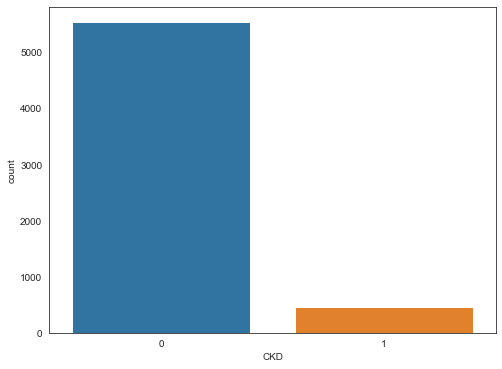

In [9]:
plt.figure(figsize=(8,6))
sns.set_style('white')

print('\n', '% positive cases', str(round(df_imputed['CKD'].astype(int).mean()*100, 1)) + '%')

sns.countplot(df_imputed['CKD'])
plt.show()

**Review the distribution of positive and negative cases across the continuous variables**

Put very (too) simply, the goal of classification problems is to distinguish between 2 (or more) classes

Therefore...


The goal is to identify variables for which there is a notable difference in distribution between the healthy patients and patients with CKD.  The variables with higher variance between classes are likely to have more influence in the model for predicting between classes.

<font color = red> 
- Age
- SBP
- Waist

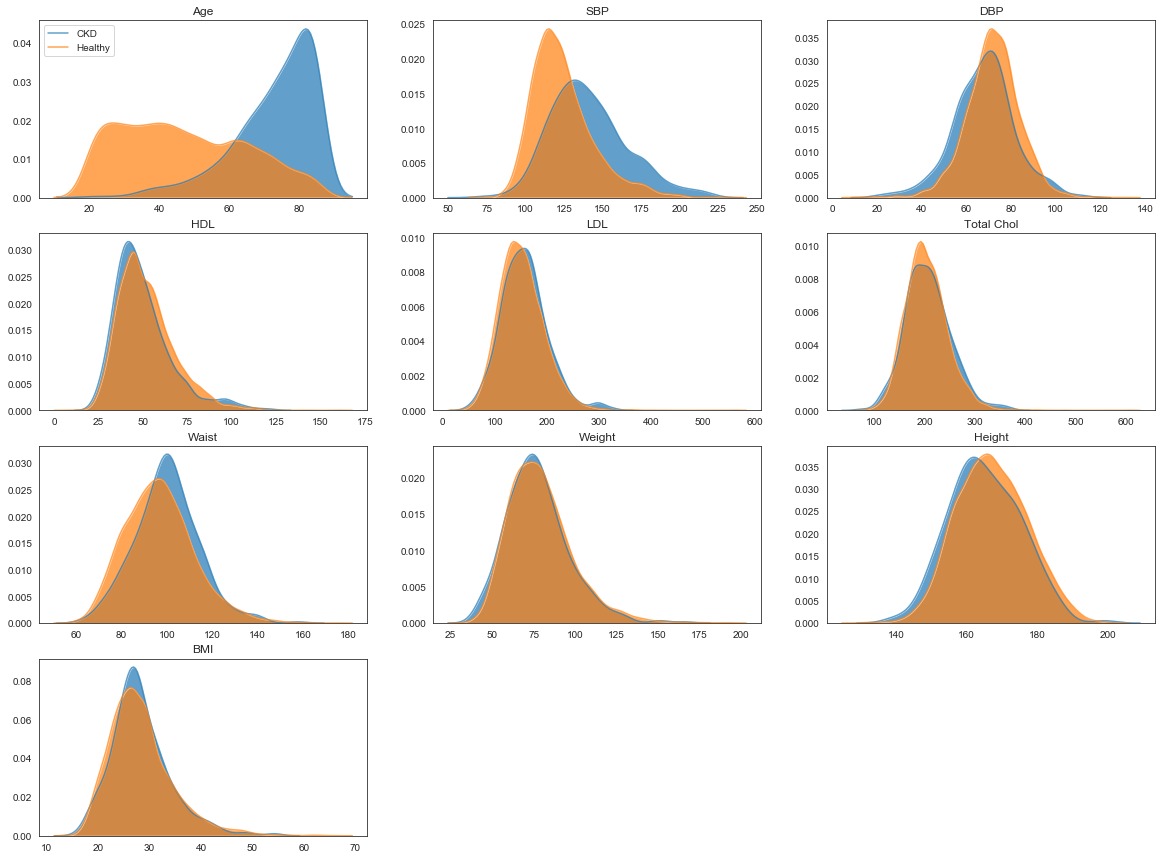

In [10]:
al = .7

plt.figure(figsize=(20,15))

for i, var in enumerate(df_imputed[continuous_cols]):
    plt.subplot(4, 3, i+1)

    sns.kdeplot(df_imputed[df_imputed['CKD'] == 1][var], shade = True, alpha = al, label = 'CKD')
    sns.kdeplot(df_imputed[df_imputed['CKD'] == 0][var], shade = True, alpha = al, label = 'Healthy')    

    plt.title(var)

    if i == 0:
        plt.legend(loc='upper left')
    else:
        plt.legend().remove()


#### Correlation
Another important step in EDA and feature engineering is to check to see if any combination of variables are highly correlated, i.e. review for **multicollinearity**


How to decide which to drop?
- is one more important to the use case than the other (qualitative consideration)?
- Does one have more of a relationship to the dependent variable?


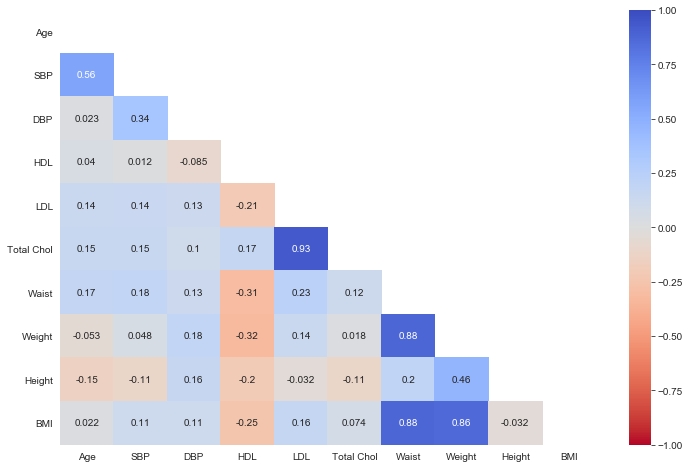

In [14]:
## Set size of plot
plt.figure(figsize = (12, 8))

## Get correlation
corr  = df_imputed[continuous_cols].corr()

mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm_r', annot = True, mask = mask)
plt.show()

Takeaway
- Weight, Height, Waist, BMI highly correlated.  
    - Use BMI, considers all as inputs

Investigate Highly correlated values (> .5)
- SBP (drop) : Age (keep)
- Total.Chol (keep) : LDL (drop)
- Waist (keep): Weight (drop)
- Waist (keep): BMI (drop)
- Weight (drop): BMI (drop)

**Categorical**

For each categorical variable, test to see if there is a statistically significant difference between the patients with/without CKD.  If the difference is not statistically significant, the variable does not add predictive value (can't distinguish between classes)




### <font color = orange> Chi-Square Test 
    
- Test if there is a "significant" relationship between a given categorical variable and the target; is the variabe relevant to the outcome being predicted.
- If there is no relationship, variable and target are independent of each other, the variable can be reasonably excluded from model
    
    
"In the case of classification problems where input variables are also categorical, we can use statistical tests to determine whether the output variable is dependent or independent of the input variables. If independent, then the input variable is a candidate for a feature that may be irrelevant to the problem and removed from the dataset.
"

In [ ]:
## Create shell of dataframe for results
df_chi2 = pd.DataFrame(index = categorical_cols, columns = ['p-value', 'Outcome'])

## Assign p-value to use to test null
alpha = 0.05

## Iterate through categorical variables
for col in categorical_cols:
    
    ## Create contingency table comparing given variable and the target
    contingency_table = pd.crosstab(df[col], df['CKD'])

    ## Run Test
    stat, p, dof, expected = chi2_contingency(contingency_table) 
    
    ## Add results to dataframe    
    df_chi2.loc[col, 'p-value'] = np.round(p, 3)
    if p <= alpha:
        df_chi2.loc[col, 'Outcome'] = 'Dependent'
    else:
        df_chi2.loc[col, 'Outcome'] = 'Independent'
    

## Display variables that can be excluded
print('Variables to exclude:',  list(df_chi2[df_chi2['Outcome'] == 'Independent'].index))
    
df_chi2   

# Modeling

Remove the varibles found in EDA to be removed
- multicolliniarity
    - Random Forest / Gradient Boosting: while the overall results of models that use bootstrapping are not impacted by multicollinearity, determining feature importance is.  Therefore, if overall results is the only concern, multicollinearity does not need to be considered.  However, if it is important to extract insight regarding which features impact the model most, it is important to consider multicollinearity and remove highly correlated variables.
- not stat. signif difference 

<font color = orange> **Certain modeling types require one hot encoding**

#### The data contains a  categorical features (Race Group, & Activity).  Let's reorder, putting the categorical features last, for creating dummy variables <font color = orange>(One Hot Encoding)
- There are many other  categorical columns, but they are all binary and therefore don't need to be encoded
- Activity: This is categorical (1- 4), BUT the categories have a natural order.  I.e. the higher the number, the more active the individual.  Therefore, the variable can be left as a number

### Final Data Prep: Variable encoding

In [ ]:
## Create dummy columns for each of the categorical variables
df_dummies_race = pd.get_dummies(df['Racegrp'], columns = list(df['Racegrp'].unique()), prefix = 'Race_')

## Add new dummy columns to original dataframe
df_dummies_all = pd.concat([df, df_dummies_race], axis = 1)

## Drop original version of categorical columns
df_dummies_all.drop('Racegrp', axis = 1, inplace = True)

df_dummies_all.head()

Structure will be to look at each modeling type, broken down into:
- Baseline: model including all features, against which feature engineered models will be compared

**Train/Test split**

In [12]:
## Split data (with dummy variables) into train/test sets
X = df_dummies_all.drop('CKD',axis=1)
X = preprocessing.scale(df_dummies_all.drop('CKD',axis=1))
y = df_dummies_all['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

NameError: name 'df_dummies_all' is not defined

# Logistic Regression


### <font color = grey> Baseline

In [10]:
## Create model instance and fit model to training data
model_LR_all = LogisticRegression()
model_LR_all.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions_LR_all = model_LR_all.predict(X_test)

model_eval(model_LR_all, y_test, predictions_LR_all)

NameError: name 'df_dummies_all' is not defined

### <font color = grey> Feature Engineering - Filter Method

In [11]:
## Remove the variables found from EDA  ()
df_post_eda = df_dummies_all.drop(['SBP', 'LDL', 'Weight', 'BMI', 'Dyslipidemia', 'Fam.Diabetes', 'Female', 'Obese'],
                                  axis = 1)

## Split data (with dummy variables) into train/test sets
X = preprocessing.scale(df_post_eda.drop('CKD',axis=1))
y = df_post_eda['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_LR_eda = LogisticRegression()
model_LR_eda.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions_LR_eda = model_LR_eda.predict(X_test)

model_eval(model_LR_eda, y_test, predictions_LR_eda)

NameError: name 'df_dummies_all' is not defined

<font color = orange> review p-values

# Random Forrest

Tree-Based doesnt require one-hot encoding


read this
https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769

In [33]:
## Ensure all other columns are treated as categorical
df.loc[:, categorical_cols] = df.loc[:, categorical_cols].copy().astype('category')

df.dtypes

C:\Users\Matt\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Age                    int64
Female              category
Racegrp             category
Educ                category
Unmarried           category
Income              category
Insured             category
Weight               float64
Height               float64
BMI                  float64
Obese               category
Waist                float64
SBP                    int64
DBP                    int64
HDL                    int64
LDL                    int64
Total.Chol             int64
Dyslipidemia        category
PVD                 category
Activity            category
PoorVision          category
Smoker              category
Hypertension        category
Fam.Hypertension    category
Diabetes            category
Fam.Diabetes        category
Stroke              category
CVD                 category
Fam.CVD             category
CHF                 category
Anemia              category
CKD                 category
dtype: object

### <font color = grey> Baseline

In [54]:
## Split data (with dummy variables) into train/test sets
X = df_dummies_all.drop('CKD',axis=1)
y = df_dummies_all['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_RF_all = RandomForestClassifier()
model_RF_all.fit(X_train,y_train)

## Use fitted model to make predictions on test data
predictions_RF_all = model_RF_all.predict(X_test)

model_eval(model_RF_all, y_test, predictions_RF_all)

Confusion Matrix: 
       0  1
0  1647  3
1   141  9 

Proft:  116700
F1 Score:  0.89 

Model Results:


,Precision,Recall,F1-score,Support
0,0.92,1.00,0.96,1650.0
1,0.75,0.06,0.11,150.0
Avg/Total,0.91,0.92,0.89,1800.0


### <font color = grey> Feature Engineering - Filter Method
    
<font color = red> **TRY BASELINE + FEATURE IMPORTANCE FITLER**

In [55]:
## Remove the variables found fromd EDA 
df_post_eda = df_dummies_all.drop(['SBP', 'Total.Chol', 'Weight', 'BMI', 'Dyslipidemia', 'Fam.Diabetes', 'Female', 'Obese'],
                                  axis = 1)

## Split data (with dummy variables) into train/test sets
X = preprocessing.scale(df_post_eda.drop('CKD',axis=1))
y = df_post_eda['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_RF_eda = RandomForestClassifier()
model_RF_eda.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions_RF_eda = model_RF_eda.predict(X_test)

model_eval(model_RF_eda, y_test, predictions_RF_eda)

Confusion Matrix: 
       0   1
0  1642   8
1   136  14 

Proft:  181200
F1 Score:  0.89 

Model Results:


,Precision,Recall,F1-score,Support
0,0.92,1.00,0.96,1650.0
1,0.64,0.09,0.16,150.0
Avg/Total,0.90,0.92,0.89,1800.0


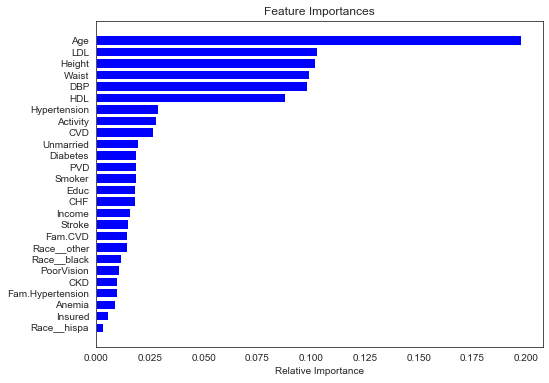

In [36]:
plt.figure(figsize=(8,6))
sns.set_style('white')

features = df_post_eda.columns
importances = model_RF_eda.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Reduce Further based on importances

In [56]:
## Remove the variables found fromd EDA 
df_post_eda = df_dummies_all[['Age', 'Height', 'Waist', 'DBP', 'LDL', 'HDL', 'Activity', 'Hypertension', 'CVD', 'CKD']]

## Split data (with dummy variables) into train/test sets
X = preprocessing.scale(df_post_eda.drop('CKD',axis=1))
y = df_post_eda['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_RF_eda = RandomForestClassifier()
model_RF_eda.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions_RF_eda = model_RF_eda.predict(X_test)

model_eval(model_RF_eda, y_test, predictions_RF_eda)

Confusion Matrix: 
       0   1
0  1632  18
1   126  24 

Proft:  310200
F1 Score:  0.9 

Model Results:


,Precision,Recall,F1-score,Support
0,0.93,0.99,0.96,1650.0
1,0.57,0.16,0.25,150.0
Avg/Total,0.90,0.92,0.90,1800.0


# Gradient Boosting: XGBoost

### <font color = grey> Baseline

In [57]:
## Split data (with dummy variables) into train/test sets
X = df_dummies_all.drop('CKD',axis=1)
X = preprocessing.scale(df_dummies_all.drop('CKD',axis=1))
y = df_dummies_all['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_XGB_all = XGBClassifier(random_state=0)
model_XGB_all.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions_XGB_all = model_XGB_all.predict(X_test)

model_eval(model_XGB_all, y_test, predictions_XGB_all)

Confusion Matrix: 
       0   1
0  1617  33
1   117  33 

Proft:  425700
F1 Score:  0.9 

Model Results:


,Precision,Recall,F1-score,Support
0,0.93,0.98,0.96,1650.0
1,0.50,0.22,0.31,150.0
Avg/Total,0.90,0.92,0.90,1800.0


### <font color = grey> Feature Engineering - Filter Method

In [58]:
## Remove the variables found fromd EDA 
df_post_eda = df_dummies_all.drop(['SBP', 'Total.Chol', 'Weight', 'BMI', 'Dyslipidemia', 'Fam.Diabetes', 'Female', 'Obese'],
                                  axis = 1)

## Split data (with dummy variables) into train/test sets
X = preprocessing.scale(df_post_eda.drop('CKD',axis=1))
y = df_post_eda['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_XGB_eda = XGBClassifier()
model_XGB_eda.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions_XGB_eda = model_XB_eda.predict(X_test)

model_eval(model_XGB_eda, y_test, predictions_XGB_eda)

Confusion Matrix: 
       0   1
0  1612  38
1   119  31 

Proft:  399200
F1 Score:  0.9 

Model Results:


,Precision,Recall,F1-score,Support
0,0.93,0.98,0.95,1650.0
1,0.45,0.21,0.28,150.0
Avg/Total,0.89,0.91,0.90,1800.0


In [65]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predictions_XGB_eda)

0.5918181818181817

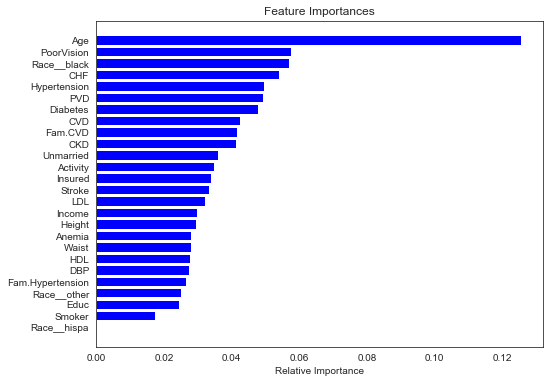

In [45]:
plt.figure(figsize=(8,6))
sns.set_style('white')

features = df_post_eda.columns
importances = model_XB_eda.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Summary of results

In [71]:
results = []

results.append(model_eval_for_df('Log Reg: Base', model_LR_all, y_test, predictions_LR_all))
results.append(model_eval_for_df('Log Reg: EDA', model_LR_eda, y_test, predictions_LR_eda))
results.append(model_eval_for_df('Rand Forrest: Base', model_RF_all, y_test, predictions_RF_all))
results.append(model_eval_for_df('Rand Forrest: EDA', model_RF_eda, y_test, predictions_RF_eda))
results.append(model_eval_for_df('Grad Boost: Base', model_XGB_all, y_test, predictions_XGB_all))
results.append(model_eval_for_df('Grad Boost: EDA', model_XGB_eda, y_test, predictions_XGB_eda))

pd.DataFrame(results, columns = ['Model Version', 'F1-Score', 'AUC','Profit']).sort_values(['F1-Score', 'AUC', 'Profit'], ascending = False)

,Model Version,F1-Score,AUC,Profit
0,Log Reg: Base,0.91,0.61,439800
4,Grad Boost: Base,0.90,0.60,425700
1,Log Reg: EDA,0.90,0.60,400600
5,Grad Boost: EDA,0.90,0.59,399200
3,Rand Forrest: EDA,0.90,0.57,310200
2,Rand Forrest: Base,0.89,0.53,116700


___

# Future Scope

This project is a work in progress.  I plan to continue working on improving the outcomes by

- Additional Feature Engineering
    - Wrapper:  RFE
    - Embedded: Lasso
    
- Imbalanced problem adjustments
    - Over/Under sample
    - SMOTE
    


___
___

**KNN Imputation** - additional considerations

- strings
    - Can handle with one-hot encoding
- <font color = red> **Uses distance metrics for neighbors -- need to standardize** 
    - min-max scaler: all values between 0-1
    
    
- Do imputing at end?
    
    
    
**Additional data prep considerations:**
- Race Group: It is always important to consider the real-world impact of the model results.  Using sensitive data such as race     

# <font color = grey> Working on further improvements
    

XGBoost

**2. Wrapper Method:  RFE**



Random

In [46]:
model = LogisticRegression()

#Initializing RFE model
rfe = RFE(model, 7)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)

print(rfe.support_)
# print(rfe.ranking_)

[ True  True False False False False False  True False False False False
 False False  True  True False False  True False False  True False False
 False False False False False False False False False False]
[ 1  1 19 16 24 18  6  1 10 11  7 20 12 15  1  1 22 14  1 27 25  1  4  8
 21 26  9  3 17  5 23  2 28 13]


In [19]:
selector = RFE(model_LR_all, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

In [53]:
selector.support_

array([ True,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [55]:
X

array([[ 0.84196784,  0.95596841, -0.88012663, ..., -0.64376017,
        -0.1808376 ,  1.00870455],
       [-0.69922179,  0.95596841, -0.88012663, ...,  1.55337352,
        -0.1808376 , -0.99137057],
       [ 0.89511231,  0.95596841, -0.88012663, ..., -0.64376017,
        -0.1808376 ,  1.00870455],
       ...,
       [-1.01808861, -1.04605967,  1.13620013, ..., -0.64376017,
        -0.1808376 , -0.99137057],
       [ 1.37341254, -1.04605967, -0.88012663, ..., -0.64376017,
        -0.1808376 , -0.99137057],
       [-0.75236626,  0.95596841,  1.13620013, ..., -0.64376017,
        -0.1808376 ,  1.00870455]])

In [21]:
selector.ranking_

array([ 1,  1, 21, 18, 26, 20,  8,  1, 12, 13,  9, 22, 14, 17,  1,  1, 24,
       16,  3, 29, 27,  2,  6, 10, 23, 28, 11,  5, 19,  7, 25,  4, 30, 15])

RFE - loop to identify optimal number of features to use

In [ ]:
selector = RFE(model_LR_all, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

In [51]:
## number of features to test 
nof_list = np.arange(1, X.shape[1]-1)            
high_score = 0

## Variable to store the optimum features
nof=0           
score_list =[]

## Loop: returns mean ACCURACY
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)
    
    model = LogisticRegression()
    
    rfe = RFE(model, n_features_to_select = nof_list[n], step=1)
    
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    
    X_test_rfe = rfe.transform(X_test)
    
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_test_rfe,y_test)
    
    score_list.append(score)
    
    print(n, score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

0 0.9166666666666666
1 0.9166666666666666
2 0.9161111111111111
3 0.9172222222222223
4 0.9188888888888889
5 0.9188888888888889
6 0.9166666666666666
7 0.9161111111111111
8 0.9155555555555556
9 0.9172222222222223
10 0.9177777777777778
11 0.9172222222222223
12 0.9216666666666666
13 0.9211111111111111
14 0.92
15 0.9205555555555556
16 0.9194444444444444
17 0.9194444444444444
18 0.9194444444444444
19 0.9188888888888889
20 0.9188888888888889
21 0.9188888888888889
22 0.92
23 0.92
24 0.9205555555555556
25 0.9216666666666666
26 0.9216666666666666
27 0.9222222222222223
28 0.9227777777777778
29 0.9227777777777778
30 0.9233333333333333
31 0.9227777777777778
Optimum number of features: 31
Score with 31 features: 0.923333


**3. Embedded Method:  Lasso**


In [ ]:
# ## Remove the variables found fromd EDA 
# df_post_eda = df_dummies_all.drop(['SBP', 'Total.Chol', 'Weight', 'BMI', 'Dyslipidemia', 'Fam.Diabetes', 'Female', 'Obese'],
#                                   axis = 1)

# ## Split data (with dummy variables) into train/test sets
# X = preprocessing.scale(df_post_eda.drop('CKD',axis=1))
# y = df_post_eda['CKD'].astype('int')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

# ## Create model instance and fit model to training data
# model_XB_eda = XGBClassifier()
# model_XB_eda.fit(X_train, y_train)

# ## Use fitted model to make predictions on test data
# predictions = model_XB_eda.predict(X_test)

# model_eval(model_XB_eda, y_test, predictions)

In [48]:
pd.DataFrame(X, columns = list(df_dummies_all.drop('CKD', axis = 1).columns))

,Age,Female,Educ,Unmarried,Income,Insured,Weight,Height,BMI,Obese,Waist,SBP,DBP,HDL,LDL,Total.Chol,Dyslipidemia,PVD,Activity,PoorVision,Smoker,Hypertension,Fam.Hypertension,Diabetes,Fam.Diabetes,Stroke,CVD,Fam.CVD,CHF,Anemia,Race__black,Race__hispa,Race__other,Race__white
0,8.42e-01,0.96,-0.88,-0.76,1.21,0.49,-1.19,-0.49,-1.14,-0.68,-0.89,0.45,-0.05,-0.24,2.27,2.20,-0.34,-0.2,1.19,-0.25,1.51,-0.81,-0.55,-0.35,1.49,-0.18,3.78,-0.69,-0.17,-0.14,-0.47,-0.64,-0.18,1.01
1,-6.99e-01,0.96,-0.88,1.31,1.21,-2.04,-0.97,-0.48,-0.89,-0.68,-1.35,-1.41,-1.59,-1.32,-0.41,-0.90,-0.34,-0.2,1.19,-0.25,-0.66,-0.81,-0.55,-0.35,-0.67,-0.18,-0.26,-0.69,-0.17,-0.14,-0.47,1.55,-0.18,-0.99
2,8.95e-01,0.96,-0.88,1.31,-0.83,0.49,0.24,-0.45,0.54,1.47,1.08,-0.50,-1.19,-0.49,1.38,1.20,2.91,-0.2,-1.26,-0.25,1.51,-0.81,-0.55,2.83,-0.67,-0.18,-0.26,-0.69,-0.17,-0.14,-0.47,-0.64,-0.18,1.01
3,2.57e-01,0.96,1.14,-0.76,-0.83,0.49,-0.50,-0.65,-0.24,-0.68,-1.26,-0.74,-1.19,1.40,0.09,0.61,-0.34,-0.2,-0.04,-0.25,1.51,-0.81,-0.55,-0.35,-0.67,-0.18,-0.26,-0.69,-0.17,-0.14,-0.47,-0.64,-0.18,1.01
4,7.36e-01,0.96,-0.88,-0.76,1.21,0.49,-0.31,-0.78,0.07,-0.68,-0.51,0.31,0.12,0.96,0.04,0.40,-0.34,-0.2,-1.26,-0.25,-0.66,1.24,-0.55,-0.35,-0.67,-0.18,-0.26,-0.69,-0.17,-0.14,2.14,-0.64,-0.18,-0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1.48e+00,-1.05,-0.88,-0.76,-0.83,0.49,1.54,1.86,0.52,1.47,1.34,1.12,0.44,-1.19,0.86,0.42,-0.34,-0.2,-0.04,-0.25,1.51,1.24,-0.55,-0.35,-0.67,-0.18,-0.26,-0.69,-0.17,-0.14,-0.47,-0.64,-0.18,1.01
5996,-8.34e-03,-1.05,-0.88,-0.76,1.21,0.49,0.38,0.18,0.31,1.47,0.17,0.21,0.28,-0.87,-0.69,-1.02,-0.34,-0.2,-0.04,-0.25,-0.66,1.24,1.83,-0.35,-0.67,-0.18,-0.26,1.44,-0.17,-0.14,-0.47,-0.64,-0.18,1.01
5997,-1.02e+00,-1.05,1.14,1.31,-0.83,0.49,-0.06,0.78,-0.47,-0.68,-0.52,0.02,0.93,-0.75,-0.50,-0.78,-0.34,-0.2,-1.26,-0.25,-0.66,-0.81,1.83,-0.35,1.49,-0.18,-0.26,1.44,-0.17,-0.14,2.14,-0.64,-0.18,-0.99
5998,1.37e+00,-1.05,-0.88,1.31,-0.83,0.49,-0.02,0.93,-0.50,-0.68,0.23,0.17,-1.76,0.39,-0.43,-0.29,-0.34,-0.2,-1.26,-0.25,1.51,1.24,-0.55,2.83,1.49,-0.18,-0.26,-0.69,-0.17,-0.14,2.14,-0.64,-0.18,-0.99


In [50]:
X

,Age,Female,Educ,Unmarried,Income,Insured,Weight,Height,BMI,Obese,Waist,SBP,DBP,HDL,LDL,Total.Chol,Dyslipidemia,PVD,Activity,PoorVision,Smoker,Hypertension,Fam.Hypertension,Diabetes,Fam.Diabetes,Stroke,CVD,Fam.CVD,CHF,Anemia,Race__black,Race__hispa,Race__other,Race__white
0,8.42e-01,0.96,-0.88,-0.76,1.21,0.49,-1.19,-0.49,-1.14,-0.68,-0.89,0.45,-0.05,-0.24,2.27,2.20,-0.34,-0.2,1.19,-0.25,1.51,-0.81,-0.55,-0.35,1.49,-0.18,3.78,-0.69,-0.17,-0.14,-0.47,-0.64,-0.18,1.01
1,-6.99e-01,0.96,-0.88,1.31,1.21,-2.04,-0.97,-0.48,-0.89,-0.68,-1.35,-1.41,-1.59,-1.32,-0.41,-0.90,-0.34,-0.2,1.19,-0.25,-0.66,-0.81,-0.55,-0.35,-0.67,-0.18,-0.26,-0.69,-0.17,-0.14,-0.47,1.55,-0.18,-0.99
2,8.95e-01,0.96,-0.88,1.31,-0.83,0.49,0.24,-0.45,0.54,1.47,1.08,-0.50,-1.19,-0.49,1.38,1.20,2.91,-0.2,-1.26,-0.25,1.51,-0.81,-0.55,2.83,-0.67,-0.18,-0.26,-0.69,-0.17,-0.14,-0.47,-0.64,-0.18,1.01
3,2.57e-01,0.96,1.14,-0.76,-0.83,0.49,-0.50,-0.65,-0.24,-0.68,-1.26,-0.74,-1.19,1.40,0.09,0.61,-0.34,-0.2,-0.04,-0.25,1.51,-0.81,-0.55,-0.35,-0.67,-0.18,-0.26,-0.69,-0.17,-0.14,-0.47,-0.64,-0.18,1.01
4,7.36e-01,0.96,-0.88,-0.76,1.21,0.49,-0.31,-0.78,0.07,-0.68,-0.51,0.31,0.12,0.96,0.04,0.40,-0.34,-0.2,-1.26,-0.25,-0.66,1.24,-0.55,-0.35,-0.67,-0.18,-0.26,-0.69,-0.17,-0.14,2.14,-0.64,-0.18,-0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1.48e+00,-1.05,-0.88,-0.76,-0.83,0.49,1.54,1.86,0.52,1.47,1.34,1.12,0.44,-1.19,0.86,0.42,-0.34,-0.2,-0.04,-0.25,1.51,1.24,-0.55,-0.35,-0.67,-0.18,-0.26,-0.69,-0.17,-0.14,-0.47,-0.64,-0.18,1.01
5996,-8.34e-03,-1.05,-0.88,-0.76,1.21,0.49,0.38,0.18,0.31,1.47,0.17,0.21,0.28,-0.87,-0.69,-1.02,-0.34,-0.2,-0.04,-0.25,-0.66,1.24,1.83,-0.35,-0.67,-0.18,-0.26,1.44,-0.17,-0.14,-0.47,-0.64,-0.18,1.01
5997,-1.02e+00,-1.05,1.14,1.31,-0.83,0.49,-0.06,0.78,-0.47,-0.68,-0.52,0.02,0.93,-0.75,-0.50,-0.78,-0.34,-0.2,-1.26,-0.25,-0.66,-0.81,1.83,-0.35,1.49,-0.18,-0.26,1.44,-0.17,-0.14,2.14,-0.64,-0.18,-0.99
5998,1.37e+00,-1.05,-0.88,1.31,-0.83,0.49,-0.02,0.93,-0.50,-0.68,0.23,0.17,-1.76,0.39,-0.43,-0.29,-0.34,-0.2,-1.26,-0.25,1.51,1.24,-0.55,2.83,1.49,-0.18,-0.26,-0.69,-0.17,-0.14,2.14,-0.64,-0.18,-0.99


In [49]:
## Split data (with dummy variables) into train/test sets
X_scaled_data = preprocessing.scale(df_dummies_all.drop('CKD',axis=1))

X = pd.DataFrame(X_scaled_data, columns = list(df_dummies_all.drop('CKD', axis = 1).columns))

y = df_post_eda['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.001129
Best score using built-in LassoCV: 0.191339


C:\Users\Matt\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26874251267577165, tolerance: 0.035328000000000026
  tol, rng, random, positive)
C:\Users\Matt\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7928260188534182, tolerance: 0.035328000000000026
  tol, rng, random, positive)
C:\Users\Matt\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08829354640204201, tolerance: 0.03372447916666666
  tol, rng, random, positive)
C:\Users\Matt\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge.

### Grid Search

In [10]:
## Split data (with dummy variables) into train/test sets
X = df_dummies_all.drop('CKD',axis=1)
X = preprocessing.scale(df_dummies_all.drop('CKD',axis=1))
y = df_dummies_all['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

In [18]:
start_time = time.time()

## Define hyperparameters to tune
param_grid = {
    'n_estimators': [25, 50, 100, 300, 500],
    'learning_rate': [0.25, 0.5, 0.1, 0.25,0.5],
    'max_depth': [3, 5, 7]
    }


## Instatiate GridSearch: creates model using optimal hyperparameters found
gs_XGB = GridSearchCV(XGBClassifier(random_state=0), param_grid = param_grid)

## Fit the resulting model to the training data
gs_XGB.fit(X_train, y_train)

## 
y_pred = gs_XGB.predict(X_test)

print(round((time.time() - start_time)/60, 1), 'minutes')

gs_XGB.best_params_

4.7 minutes


{'learning_rate': 0.25, 'max_depth': 5, 'n_estimators': 25}

In [17]:
## Split data (with dummy variables) into train/test sets
X = df_dummies_all.drop('CKD',axis=1)
X = preprocessing.scale(df_dummies_all.drop('CKD',axis=1))
y = df_dummies_all['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_GB_all = XGBClassifier(random_state=0,
                             learning_rate = 0.1,
                             max_depth = 5,
                             n_estimators = 100)
model_GB_all.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions = model_GB_all.predict(X_test)

model_eval(model_GB_all, y_test, predictions)

Confusion Matrix: 
       0   1
0  1624  26
1   121  29 

Proft:  374400
F1 Score:  0.9 

Model Results:


,Precision,Recall,F1-score,Support
0,0.93,0.98,0.96,1650.0
1,0.53,0.19,0.28,150.0
Avg/Total,0.90,0.92,0.90,1800.0
